# Winter Resort Visitation Prediction - Resort 2

*Capstone Data Science Project / Flatiron Data Science Bootcamp*

By: [Lenore Perconti](https://github.com/lperconti)

## Overview

In this project I look at three winter resorts and utilize weather and event data to predict visitation for each resort. This notebook looks at Resort 2. 

### The Stakeholder / Business Problem

For a full, detailed stakeholder and business problem introduction, see the [Read.Me](https://github.com/lperconti/Visitation/blob/main/README.md) file. 

# EDA

We'll first load the dataset and do some exploration. 

This resort is our smallest ski resort with the smallest population center nearby, approx 85,000. They report that their limiting factor for daily visitations is their parking lot, which typically tops capacity off at 3,000 visitors and prevents the mountain from becoming too overcrowded. Their lift capacity is 5300 riders per hour. This mountain is a 501(c)3 nonprofit organization, and they generously gave 6 seasons worth of daily visitor data for use in this project. 

It's also worth noting that this moutain is closed on Tuesday and Wednesday unless those days fall during the holidays. 

A couple notes on getting the data for this particular ski area: 

* They are typically closed on Tuesdays and Wednesdays except for over the winter holidays. 
* Mountain Weather Data was gathered from a nearby SNOTEL station that was not at the ski area (6.9 miles away). This ski area has a private weather station that has only started gathering weather data in the last year. 
* Wind data was not availible for the nearest town
* This ski resort only was open a handful of days during 2018 due to lack of snow and unusually warm weather all winter. 

After cleaning: 

- Dataset count     468.000000

Daily Visitors stats:
- mean      992.083333
- std       586.503671
- min        88.000000
- 25%       557.250000
- 50%       887.500000
- 75%      1329.250000
- max      2944.000000

In [1]:
#imports

#libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#libraries for modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xg

#libraries for evaluation
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

In [2]:
#Load the dataset, take a look at the data info: 
df_2 = pd.read_csv('Data/Resort_2.csv', thousands=',')
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 644 entries, 0 to 643
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              644 non-null    object 
 1   IS_SCHOOL_OUT     644 non-null    int64  
 2   IS_HOLIDAY        644 non-null    int64  
 3   Skier visits day  644 non-null    int64  
 4   SV Nights         557 non-null    float64
 5   TOTAL_VISITS      644 non-null    int64  
 6   M_TEMPAVERAGE_F   644 non-null    int64  
 7   M_PRECIP_INCHES   643 non-null    float64
 8   T_PRCP            644 non-null    float64
 9   T_TMAX            644 non-null    int64  
 10  T_TMIN            644 non-null    int64  
 11  T_TAVG            644 non-null    float64
dtypes: float64(4), int64(7), object(1)
memory usage: 60.5+ KB


In [3]:
#See if there's any duplicates: 
df_2.duplicated().value_counts()

False    582
True      62
dtype: int64

In [4]:
#Drop Duplicates, check to see if we got rid of them:
df_2.drop_duplicates(subset=['Date'], inplace=True)
df_2['Date'].duplicated().value_counts()

False    561
Name: Date, dtype: int64

Make the `Date` column a datetime object, create day of week and month category, we'll use these variables in our models to see if they have any predictive power.

In [5]:
#Date dealings - make the 'Date' column a datetime object, create day of week and month category to do some EDA and use as variables
#make the 'Date' Column a datetime type
df_2['Date'] = pd.to_datetime(df_2['Date'])

#The day_of_week_num column created with Monday=0, Sunday=6. Weekends = 5 & 6, Friday = 4
df_2['day_of_week_num'] = df_2['Date'].dt.dayofweek

#The month column created
df_2['Month'] = df_2['Date'].dt.month

df_2['day_of_week_num'].value_counts()

5    113
6    112
4    108
3     97
0     97
2     18
1     16
Name: day_of_week_num, dtype: int64

In [6]:
df_2.describe()

,IS_SCHOOL_OUT,IS_HOLIDAY,Skier visits day,SV Nights,TOTAL_VISITS,M_TEMPAVERAGE_F,M_PRECIP_INCHES,T_PRCP,T_TMAX,T_TMIN,T_TAVG,day_of_week_num,Month
count,561.000000,561.000000,561.000000,474.000000,561.000000,561.000000,560.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000
mean,0.181818,0.062389,786.064171,61.061181,837.655971,32.203209,0.238571,0.082852,52.386809,30.814617,41.599822,3.586453,4.495544
std,0.386039,0.242076,634.459570,179.047829,673.695444,6.974806,0.402601,0.168418,9.027840,6.199182,6.480177,2.039808,4.242270
min,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000,32.000000,11.000000,21.500000,0.000000,1.000000
25%,0.000000,0.000000,305.000000,0.000000,329.000000,27.000000,0.000000,0.000000,46.000000,27.000000,37.000000,3.000000,2.000000
50%,0.000000,0.000000,683.000000,0.000000,745.000000,32.000000,0.100000,0.000000,51.000000,31.000000,41.000000,4.000000,3.000000
75%,0.000000,0.000000,1167.000000,0.000000,1239.000000,37.000000,0.300000,0.090000,58.000000,34.000000,46.000000,5.000000,4.000000
max,1.000000,1.000000,3575.000000,1825.000000,5127.000000,51.000000,2.600000,1.120000,86.000000,51.000000,63.000000,6.000000,12.000000


In [7]:
df_2.isna().sum()

Date                 0
IS_SCHOOL_OUT        0
IS_HOLIDAY           0
Skier visits day     0
SV Nights           87
TOTAL_VISITS         0
M_TEMPAVERAGE_F      0
M_PRECIP_INCHES      1
T_PRCP               0
T_TMAX               0
T_TMIN               0
T_TAVG               0
day_of_week_num      0
Month                0
dtype: int64

In [8]:
#Dropping the one NAN value in M_PRECIP_INCHES
df_2.dropna(subset=['M_PRECIP_INCHES'], inplace=True)
df_2['M_PRECIP_INCHES'].isna().value_counts()

False    560
Name: M_PRECIP_INCHES, dtype: int64

# Correlation Matrix 
Let's start exploring correlation, taking out `TOTAL_VISITS` (our target), SP, Day and Night related ticket totals to see if any of our variables are highly correlated. Also taking out `Date` as the specific date is not a predictor. 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 560 entries, 0 to 643
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   IS_SCHOOL_OUT     560 non-null    int64  
 1   IS_HOLIDAY        560 non-null    int64  
 2   Skier visits day  560 non-null    int64  
 3   SV Nights         474 non-null    float64
 4   M_TEMPAVERAGE_F   560 non-null    int64  
 5   M_PRECIP_INCHES   560 non-null    float64
 6   T_PRCP            560 non-null    float64
 7   T_TMAX            560 non-null    int64  
 8   T_TMIN            560 non-null    int64  
 9   T_TAVG            560 non-null    float64
 10  day_of_week_num   560 non-null    int64  
 11  Month             560 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 56.9 KB


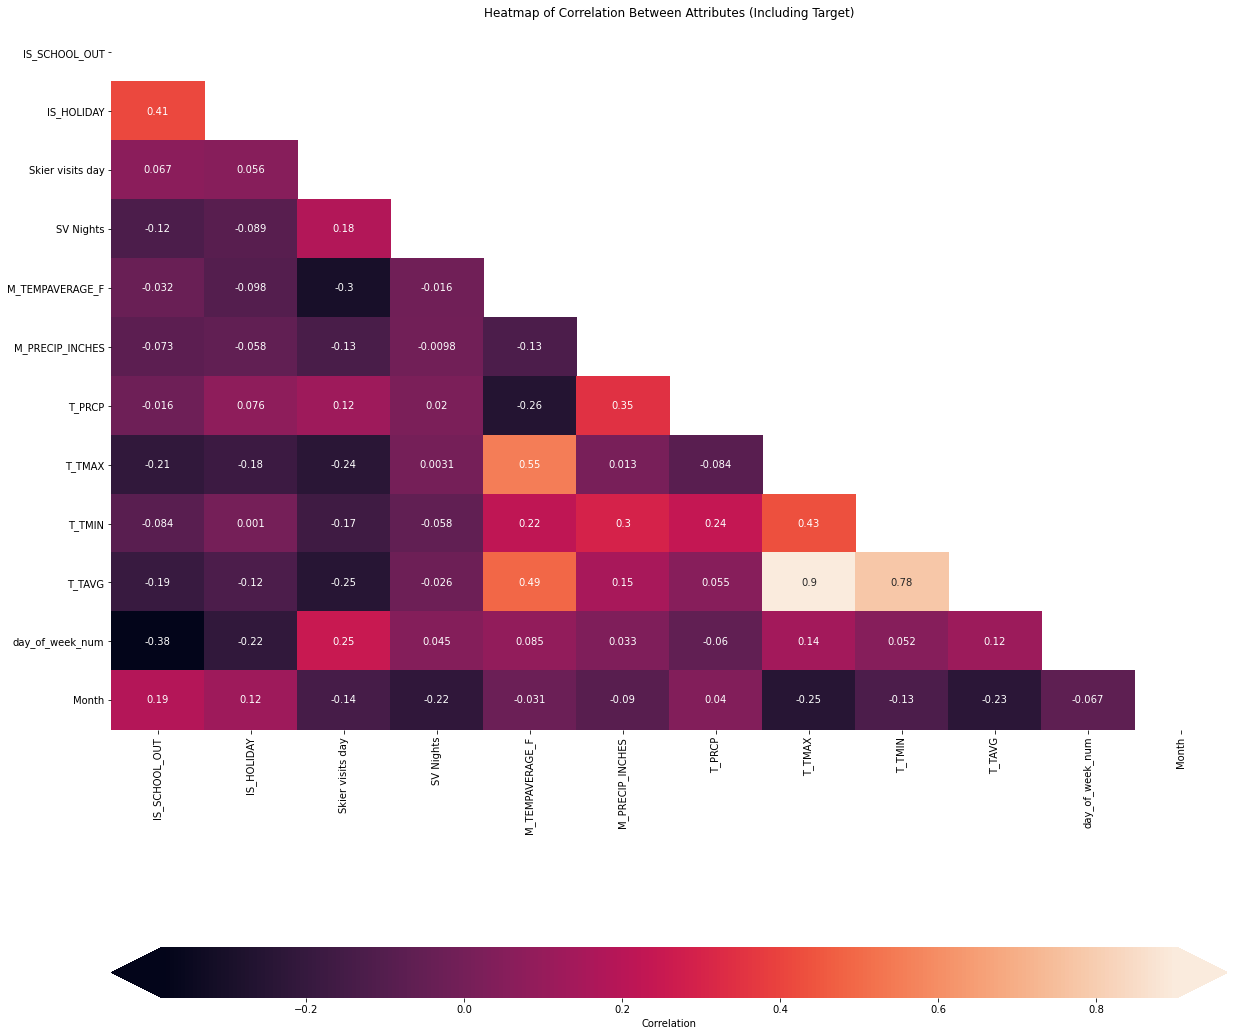

In [9]:
#removing predictor (visit) and date columns for correlation testing

df_2_corr = df_2.drop(columns=['Date', 'TOTAL_VISITS'])
df_2_corr.info()

# Create a df with the target as the first column,
# then compute the correlation matrix
heatmap_data = df_2_corr
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(20, 20))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(data=corr, mask=np.triu(np.ones_like(corr, dtype=bool)), ax=ax, annot=True, 
            cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"})

ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

In [10]:
#identifying the highest correlated variables

df = df_2_corr.corr().abs().stack().reset_index().sort_values(0, ascending=False)

df['pairs'] = list(zip(df.level_0, df.level_1))

df.set_index(['pairs'], inplace = True)

df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
df.columns = ['cc']

df.drop_duplicates(inplace=True)

df[(df.cc>.75) & (df.cc<1)]


,cc
pairs,
"(T_TAVG, T_TMAX)",0.902177
"(T_TAVG, T_TMIN)",0.778168


### Multicollinairity decision

Based on the information above it makes sense to drop the Town Max Temperature (`T_TMAX`) and the Town Min Temperature (`T_MIN`)

**Ticketing:**

To keep things simple I think for now I am going to remove the ticketing and visit informatoin that breaks down season pass vs ticket and night vs day ticketing. I may want to use these as a prediction if there's time or the business need becomes obvious. Unfortunately I don't have pre-sale data to work with. 

- `SV Nights`
- `Skiier Visits Day`

In [11]:
df_2_preprocessed = df_2.drop(columns=['T_TMAX', 'T_TMIN', 'SV Nights', 'Skier visits day'])
df_2_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 560 entries, 0 to 643
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             560 non-null    datetime64[ns]
 1   IS_SCHOOL_OUT    560 non-null    int64         
 2   IS_HOLIDAY       560 non-null    int64         
 3   TOTAL_VISITS     560 non-null    int64         
 4   M_TEMPAVERAGE_F  560 non-null    int64         
 5   M_PRECIP_INCHES  560 non-null    float64       
 6   T_PRCP           560 non-null    float64       
 7   T_TAVG           560 non-null    float64       
 8   day_of_week_num  560 non-null    int64         
 9   Month            560 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(6)
memory usage: 48.1 KB


## 0 visit days
Taking a look at rows with 0 visits (these are the days the resort is closed)

In [12]:
df_2_preprocessed[df_2_preprocessed.TOTAL_VISITS == 0]

,Date,IS_SCHOOL_OUT,IS_HOLIDAY,TOTAL_VISITS,M_TEMPAVERAGE_F,M_PRECIP_INCHES,T_PRCP,T_TAVG,day_of_week_num,Month
26,2016-01-17,0,0,0,34,1.4,0.42,44.5,6,1
67,2016-03-13,0,0,0,31,2.3,0.25,43.5,6,3
88,2016-12-01,0,0,0,25,0.0,0.08,42.0,3,12
89,2016-12-02,0,0,0,31,0.2,0.00,35.5,4,12
90,2016-12-03,0,0,0,32,0.0,0.00,35.0,5,12
...,...,...,...,...,...,...,...,...,...,...
480,2019-12-01,0,0,0,30,0.5,0.10,32.5,6,12
481,2019-12-02,0,0,0,35,0.1,0.00,45.0,0,12
482,2019-12-05,0,0,0,36,0.0,0.00,37.0,3,12
483,2019-12-06,0,0,0,36,0.3,0.00,44.5,4,12


In [13]:
#dropping the 0 visit days: 
df_2_preprocessed = df_2_preprocessed[df_2_preprocessed.TOTAL_VISITS != 0]
df_2_preprocessed['TOTAL_VISITS'].value_counts()

1026    3
270     3
1548    3
390     3
435     3
       ..
1637    1
1641    1
618     1
1474    1
1505    1
Name: TOTAL_VISITS, Length: 407, dtype: int64

## Indexing with Date

In [14]:
#df_2_preprocessed.reset_index(inplace=True)
df_2_preprocessed.set_index('Date', inplace=True)
df_2_preprocessed.head(2)

,IS_SCHOOL_OUT,IS_HOLIDAY,TOTAL_VISITS,M_TEMPAVERAGE_F,M_PRECIP_INCHES,T_PRCP,T_TAVG,day_of_week_num,Month
Date,,,,,,,,,
2015-12-14,0,0,755,24,0.5,1.05,35.0,0,12
2015-12-17,0,0,735,35,0.1,0.13,34.0,3,12


# Visualizations


Month
1     1171.0
2      980.0
3      656.5
4      508.0
12     922.0
Name: TOTAL_VISITS, dtype: float64


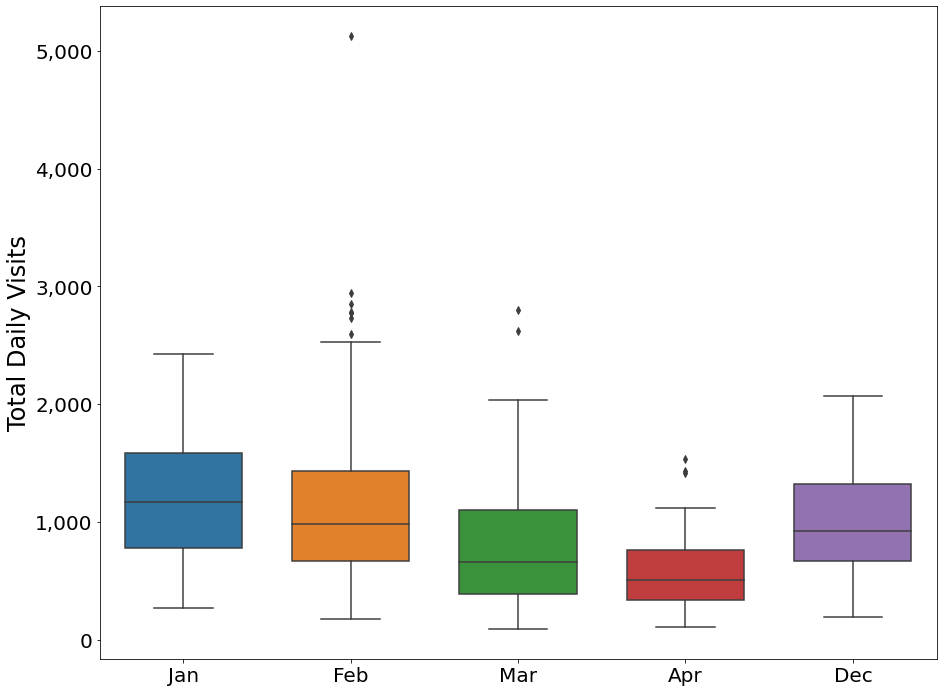

In [15]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(15, 12))
sns.boxplot(x='Month', y='TOTAL_VISITS', data=df_2_preprocessed, width=.7)

medians = df_2_preprocessed.groupby(['Month'])['TOTAL_VISITS'].median()
print(medians)

ax.set_xlabel("")

ax.set_ylabel("Total Daily Visits", fontsize=24)

plt.yticks(fontsize=20)

plt.xticks([0, 1, 2, 3, 4], ['Jan', 'Feb', 'Mar', 'Apr', 'Dec'], fontsize=20)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


plt.savefig('Visuals/resort2visits.png', dpi=300);

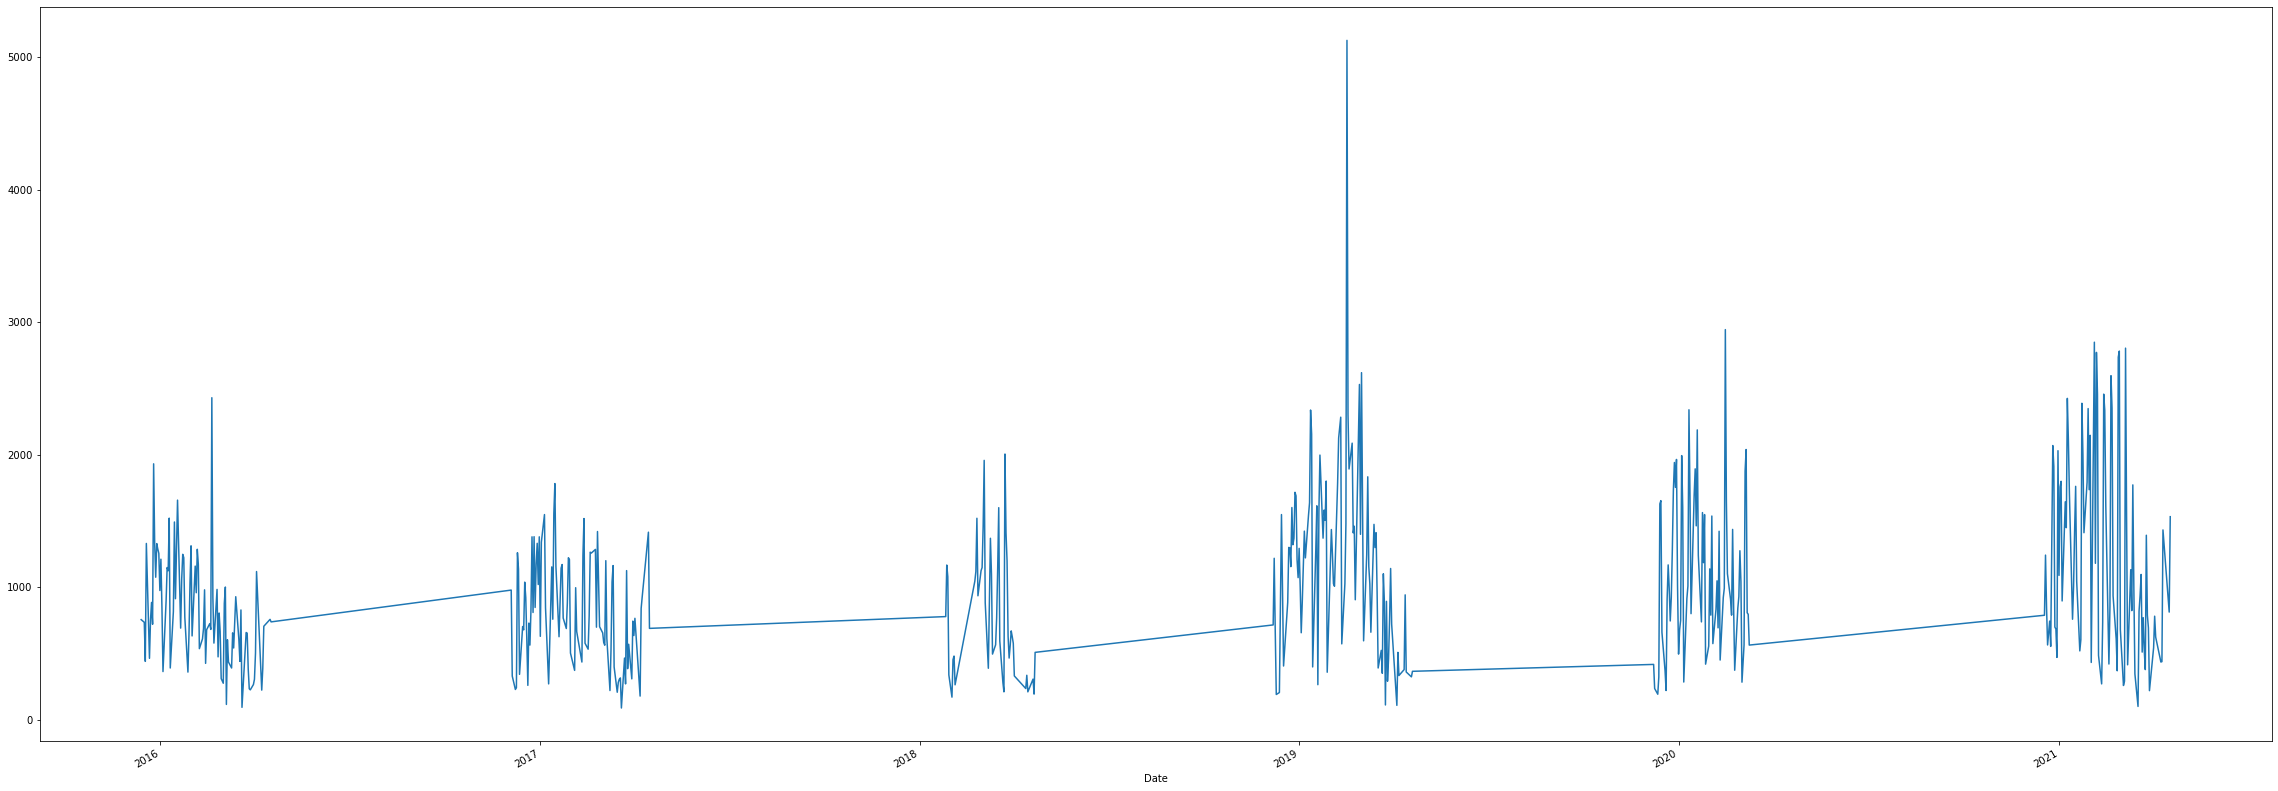

In [16]:
df_2_preprocessed['TOTAL_VISITS'].plot(figsize = (40, 15));

Let's look at the relationship between visitors and Precipitation on the Mountain: 

In [17]:
#identified 5,000 + skiier visit day, that is way over capacity for this resort, going to drop that row

df_2_preprocessed = df_2_preprocessed[df_2_preprocessed.TOTAL_VISITS <= 5000]
df_2_preprocessed['TOTAL_VISITS'].describe()

count     468.000000
mean      992.083333
std       586.503671
min        88.000000
25%       557.250000
50%       887.500000
75%      1329.250000
max      2944.000000
Name: TOTAL_VISITS, dtype: float64

Looking at relationshp between day of week and visits: 

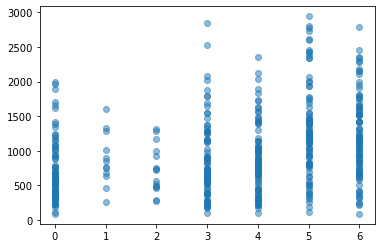

In [18]:
fig, ax = plt.subplots()

ax.scatter(df_2_preprocessed['day_of_week_num'], df_2_preprocessed['TOTAL_VISITS'], alpha=0.5)

Let's look at the relationship between visitors and Precipitation on the Mountain: 

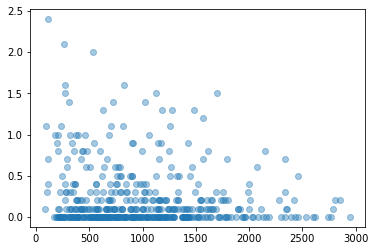

In [20]:
#relationship between mountain precipitataion and visits
plt.scatter(y=df_2_preprocessed['M_PRECIP_INCHES'], x=df_2_preprocessed['TOTAL_VISITS'], alpha=.4)
plt.savefig('Visuals/resort2precip.png', dpi=300);

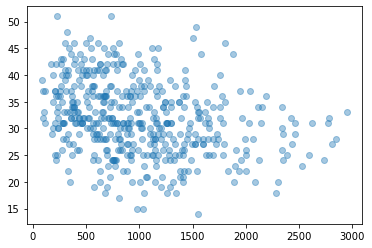

In [21]:
#relationship between mountain temperature and visits
plt.scatter(y=df_2_preprocessed['M_TEMPAVERAGE_F'], x=df_2_preprocessed['TOTAL_VISITS'], alpha=.4)
plt.savefig('Visuals/resort2mountaintemp.png', dpi=300);

At first glance, calendar events seem to have more impact on visitation: 

IS_HOLIDAY
0     981.613636
1    1156.607143
Name: TOTAL_VISITS, dtype: float64
day_of_week_num
0     713.634146
1     877.416667
2     734.400000
3     877.670886
4     872.489130
5    1283.755319
6    1212.276596
Name: TOTAL_VISITS, dtype: float64


<AxesSubplot:xlabel='M_PRECIP_INCHES', ylabel='TOTAL_VISITS'>

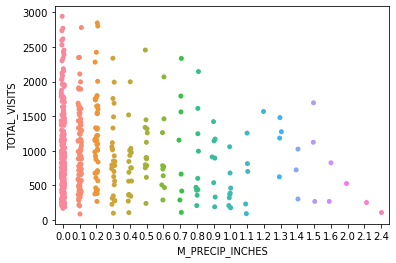

In [22]:
Holiday_averages=df_2_preprocessed.groupby(df_2_preprocessed['IS_HOLIDAY'])['TOTAL_VISITS'].mean()
print(Holiday_averages)

Schoolout_averages=df_2_preprocessed.groupby(df_2_preprocessed['day_of_week_num'])['TOTAL_VISITS'].mean()
print(Schoolout_averages)

fig, ax = plt.subplots()
sns.stripplot(x='M_PRECIP_INCHES', y='TOTAL_VISITS', data=df_2_preprocessed)

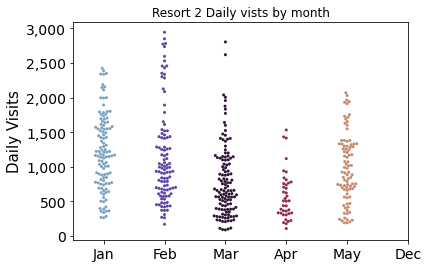

In [23]:
fig, ax = plt.subplots()
sns.swarmplot(x='Month', y='TOTAL_VISITS', data=df_2_preprocessed, size=3, palette='twilight', edgecolor='none')

ax.set_xlabel("")
ax.set_title("Resort 2 Daily vists by month")
ax.set_ylabel("Daily Visits", fontsize=15)
plt.yticks(fontsize=14)
plt.xticks([0, 1, 2, 3, 4, 5], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Dec'], fontsize=14)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('Visuals/resort2swarmplotmonth.png', dpi=300);

### Saving Cleaned Resort 3 Data to CSV for reference and Modeling: 

In [24]:
df_2_preprocessed.to_csv("Data/DF_2_clean.csv")

# Modeling

First we will split the data into train and test, check to make sure our split worked, then establish categorical vs non-categorical lists for transformations. Then we'll run a Linear Regression for our baseline Model

In [26]:
#Split into test and train X and Y
X = df_2_preprocessed.drop(columns=['TOTAL_VISITS'])
y = df_2_preprocessed['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
y.head()

Date
2015-12-14     755
2015-12-17     735
2015-12-18     440
2015-12-19    1330
2015-12-22     463
Name: TOTAL_VISITS, dtype: int64

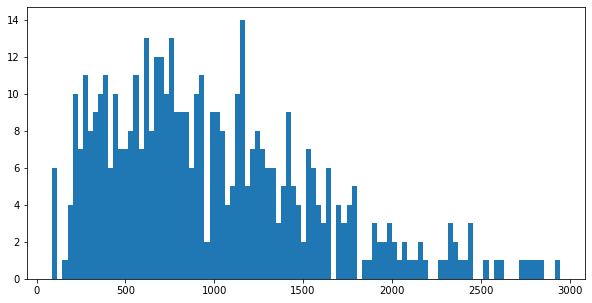

In [28]:
#visualization of target - Visits
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(y, bins=100);

In [32]:
cat = ['IS_HOLIDAY', 'IS_SCHOOL_OUT', 'day_of_week_num', 'Month']
non_cat = ['M_TEMPAVERAGE_F', 'M_PRECIP_INCHES', 'T_PRCP', 'T_TAVG',]

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	('scaler', StandardScaler(), non_cat),
	], remainder ='passthrough')

In [50]:
#setting up the pipe and training the model: 

LRPipe = Pipeline([('transformer', Transformer),
                ('linreg', LinearRegression())])

LRPipe.fit(X_train, y_train)

#cross validation and scoring
cv_LR = cross_validate(LRPipe, X_train, y_train, return_train_score=True, cv=5)
cv_score_LR = cross_val_score(LRPipe, X_train, y_train, cv = 5)

print(f'Cross Validation Scores, Linear Regression: {cv_LR}')

print(f'mean CV Score, Linear Regression, Resort 3: {cv_score_LR.mean()}')

Cross Validation Scores, Linear Regression: {'fit_time': array([0.01840806, 0.02794576, 0.03901792, 0.01354289, 0.02406979]), 'score_time': array([0.00672889, 0.01302719, 0.03427315, 0.00688696, 0.01337218]), 'test_score': array([0.28257942, 0.4323264 , 0.30614113, 0.44314372, 0.37770194]), 'train_score': array([0.46812703, 0.43163345, 0.46334598, 0.40690056, 0.43786621])}
mean CV Score, Linear Regression, Resort 3: 0.36837852134953586


With Encoding and scaling, the mean Basic Linear Regression CV score is 0.368

There is definitly some room for improvement, it's expected that this resort wouldn't perform as well in general with less features and a smaller sample set. 

# Tree Regressor

In [40]:
Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')
	
#Pipeline second Step: treeregressor
dt_clf2 = DecisionTreeRegressor(random_state = 42)

#pipeline
pipeline_dt = Pipeline([('transformer', Transformer),
						('dtr', dt_clf2)])

#set up grid search paramater grid
dt_param_grid = {
    'dtr__min_samples_split': [2, 4, 6, 8],
    'dtr__max_depth': [None, 2, 3, 4, 5, 6]
}

#set up gridsearch:
gridsearch_dt = GridSearchCV(estimator=pipeline_dt,
						  param_grid=dt_param_grid,
						  cv=5)

#fit gridsearch
gridsearch_dt.fit(X_train, y_train)

print("Best Parameter Combination for Tree Regressor Found During Grid Search:")
print(gridsearch_dt.best_params_)

Best Parameter Combination for Tree Regressor Found During Grid Search:
{'dtr__max_depth': 4, 'dtr__min_samples_split': 2}


In [35]:
Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
dt_clf3 = DecisionTreeRegressor(max_depth=4, min_samples_split=2, random_state = 42)

#pipeline
pipeline_dt_best = Pipeline([('transformer', Transformer),
						('dtr', dt_clf3)])


pipeline_dt_best.fit(X_train, y_train)

cv = cross_validate(pipeline_dt_best, X_train, y_train, return_train_score=True, cv=5)
cv_score = cross_val_score(pipeline_dt_best, X_train, y_train, cv = 5)
print(f'Cross Validation Scores bDecision treeest Decision Tree Regressor: {cv}')

print(f'mean CV Score: {cv_score.mean()}')

Cross Validation Scores bDecision treeest Decision Tree Regressor: {'fit_time': array([0.00753903, 0.01028705, 0.0129931 , 0.0070591 , 0.00958681]), 'score_time': array([0.00675297, 0.00323677, 0.0070591 , 0.00726795, 0.00819302]), 'test_score': array([ 0.05195258, -0.00276326,  0.2437818 ,  0.43718259,  0.25705477]), 'train_score': array([0.49624686, 0.52308895, 0.49555474, 0.45869514, 0.45705384])}
mean CV Score: 0.19744169507472503


#### Tree Regressor Results: 

The tree regressor did not perform well at all at a mean CV score of 0.197, Linear Regression baseline is our best model so far. 

## Random Forests

In [39]:
Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
rfr = RandomForestRegressor(random_state = 42)

#pipeline
pipeline_rfr = Pipeline([('transformer', Transformer),
						('dtr', rfr)])

#set up grid search paramater grid
rfr_param_grid = {
    'dtr__n_estimators': [2, 4, 6, 8, 10, 12, 14, 16],
    'dtr__max_depth': [None, 2, 3, 4, 5, 6, 8, 10],
	'dtr__max_features': ['auto', 'sqrt', 'log2'],
	'dtr__criterion': ['mse', 'mae']
}

#set up gridsearch:
gridsearch_rfr = GridSearchCV(estimator=pipeline_rfr,
						  param_grid=rfr_param_grid,
						  cv=5)

#fit gridsearch
gridsearch_rfr.fit(X_train, y_train)

print("Best Parameter Combination Found During Grid Search:")
print(gridsearch_rfr.best_params_)

Best Parameter Combination Found During Grid Search:
{'dtr__criterion': 'mse', 'dtr__max_depth': None, 'dtr__max_features': 'sqrt', 'dtr__n_estimators': 14}


In [38]:
#Pipeline second Step: treeregressor
rfr_best = RandomForestRegressor(criterion = 'mse', max_depth = None, max_features = 'sqrt', n_estimators = 14, random_state = 42)

#pipeline
pipeline_rfr_best = Pipeline([('transformer', Transformer),
						('dtr', rfr_best)])


pipeline_rfr_best.fit(X_train, y_train)

cv = cross_validate(pipeline_rfr_best, X_train, y_train, return_train_score=True, cv=5)
cv_score = cross_val_score(pipeline_rfr_best, X_train, y_train, cv = 5)
print(f'Cross Validation Scores best Random Forest Regressor: {cv}')

print(f'mean CV Score: {cv_score.mean()}')

Cross Validation Scores best Random Forest Regressor: {'fit_time': array([0.03763413, 0.03834605, 0.05020905, 0.04385114, 0.10214591]), 'score_time': array([0.00965309, 0.01098013, 0.00519919, 0.0108459 , 0.01234317]), 'test_score': array([0.29942731, 0.2866601 , 0.3382997 , 0.5334384 , 0.37849704]), 'train_score': array([0.89006491, 0.90713752, 0.90591733, 0.89313038, 0.89171365])}
mean CV Score: 0.3672645072153229


Mean CV Score from Random Forest Regressor: 0.367, performing about the same as Linear Regression Model. 

# Gradient Boosting: 

In [41]:
GBR = GradientBoostingRegressor(random_state = 42)

pipeline_gbr = Pipeline([('transformer', Transformer),
						('gbr', GBR)])

#set up grid search paramater grid
gbr_param_grid = {
    'gbr__n_estimators': [50, 100, 200, 300],
    'gbr__criterion': ['friedman_mse', 'mse', 'mae'],
	'gbr__min_samples_split': [2, 3, 4, 5]

}

#set up gridsearch:
gridsearch_gbr = GridSearchCV(estimator=pipeline_gbr,
						  param_grid=gbr_param_grid,
						  cv=5)

#fit gridsearch
gridsearch_gbr.fit(X_train, y_train)

print("Best Parameter Combination Found During GBR Grid Search:")
print(gridsearch_gbr.best_params_)

Best Parameter Combination Found During GBR Grid Search:
{'gbr__criterion': 'mae', 'gbr__min_samples_split': 3, 'gbr__n_estimators': 100}


In [42]:
GBR_best = GradientBoostingRegressor(criterion='mae', n_estimators=100, min_samples_split= 3, random_state = 42)

#pipeline
pipeline_gbr_best = Pipeline([('transformer', Transformer),
						('gbr', GBR_best)])

pipeline_gbr_best.fit(X_train, y_train)


cv = cross_validate(pipeline_gbr_best, X_train, y_train, return_train_score=True, cv=5)
cv_score = cross_val_score(pipeline_gbr_best, X_train, y_train, cv = 5)
print(f'Cross Validation Score Gradient Boosting Model: {cv}')

print(f'mean CV Score: {cv_score.mean()}')

Cross Validation Score Gradient Boosting Model: {'fit_time': array([0.78574896, 0.76767802, 0.77599287, 0.77399087, 0.78102183]), 'score_time': array([0.0036521 , 0.0049417 , 0.00446415, 0.0049541 , 0.003613  ]), 'test_score': array([0.22191143, 0.28673029, 0.41578585, 0.43083362, 0.36807175]), 'train_score': array([0.66893549, 0.70887161, 0.69396347, 0.65825949, 0.67160523])}
mean CV Score: 0.34466658592211086


Gradient Boosting Regressor isn't working to improve our score from our baseline. We'll see if X Boost can help at all: 

# X-Boost

In [43]:
Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	('scaler', StandardScaler(), non_cat),
	], remainder ='passthrough')

xgb_r = xg.XGBRegressor(seed = 123)

#pipeline
xboostPipe = Pipeline([('transformer', Transformer),
						('xgb_r', xgb_r)])

# objective ='reg:squarederror', n_estimators = 10, 
boost_param_grid = {
    'xgb_r__eta': [.2, .3, .4, .5, .6, .7, .8],
	'xgb_r__max_depth': [3, 4, 5, 6, 7, 8, 9, 10]
}

gridsearch_boost = GridSearchCV(estimator=xboostPipe,
						  param_grid=boost_param_grid,
						  cv=5)

#fit gridsearch
gridsearch_boost.fit(X_train, y_train)

print("Best Parameter Combination Found During XBoost Grid Search:")
print(gridsearch_boost.best_params_)


Best Parameter Combination Found During XBoost Grid Search:
{'xgb_r__eta': 0.2, 'xgb_r__max_depth': 3}


In [45]:
Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	('scaler', StandardScaler(), non_cat),
	], remainder ='passthrough')

#Pipeline second Step: 
xgb_r_best = xg.XGBRegressor(eta = 0.2, max_depth = 3, seed = 123)

xboost_pipe_best = Pipeline([('transformer', Transformer),
						('xgb_r_2', xgb_r_best)])

xboost_pipe_best.fit(X_train, y_train)

cv = cross_validate(xboost_pipe_best, X_train, y_train, return_train_score=True, cv=5)
cv_score = cross_val_score(xboost_pipe_best, X_train, y_train, cv = 5)
print(f'Cross Validation Scores X Boost: {cv}')

print(f'mean CV Score X Boost: {cv_score.mean()}')

Cross Validation Scores X Boost: {'fit_time': array([0.33928275, 0.45907998, 0.09654307, 0.05485892, 0.04526401]), 'score_time': array([0.05952311, 0.00986028, 0.01068997, 0.00937128, 0.00812817]), 'test_score': array([0.21493312, 0.1285273 , 0.33142021, 0.48573498, 0.44935229]), 'train_score': array([0.8429729 , 0.85418615, 0.83561323, 0.82875331, 0.8375591 ])}
mean CV Score X Boost: 0.32199357990204097


X Boost is not performing well either. 

# Evaluation

Evaluating Linear Regression model on our test data: 

In [46]:
LRPipe.score(X_test, y_test)

0.3947126851746343

In [48]:
y_pred_LR = LRPipe.predict(X_test)

df = pd.DataFrame({'Real Visits Resort 1':y_test, 'Predicted XBoost Visits':y_pred_LR, 
                    'Difference': abs(y_test - y_pred_LR)})
print('Mean Difference, predicted - actual')
print(df['Difference'].mean())
df.head()

Mean Difference, predicted - actual
305.0531914893617


,Real Visits Resort 1,Predicted XBoost Visits,Difference
Date,,,
2016-02-28,665,1336.0,671.0
2016-03-10,390,304.0,86.0
2016-01-29,641,1124.0,483.0
2019-03-27,290,484.0,194.0
2016-03-24,658,900.0,242.0


For this small resort, where they top out at about 3,000 visitors, +/- 305 visitors is a decent predictor for this resort. 


## further analyze? How? Feature Importance? 